In [27]:
# Instalar bibliotecas necesarias
!pip install pandas glob2 matplotlib numpy seaborn librosa resampy tensorflow scikit-learn

In [28]:
import os
import librosa
import pandas as pd
import glob2 as glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Preprocesamiento y Limpieza de Datos
## Antes de procesar los conjuntos de datos seleccionados, debemos preprocesarlos o limpiarlos para asegurarnos de que no haya datos sucios y extraer aquellos en los que solo estamos interesados en procesar más tarde.

## En primer lugar, enumeremos todos los Archivos de Audio y sus emociones correspondientes utilizando sus nombres de archivo (afortunadamente para nosotros, estos ya están bien etiquetados por la Universidad de Toronto).

In [29]:
# Enter Dataset folder
data_folder = 'dataset'

# Listing all .wav files in the dataset
file_paths = glob.glob(f"{data_folder}/**/*.wav", recursive=True)

# Parsing emotion labels and file paths into a pandas DataFrame
data = []
for file_path in file_paths:
    # Extracting emotion from the file path
    parts = file_path.split(os.sep)

    emotion = parts[-2]

    # Adding file path and emotion to the list
    data.append({'emotion': emotion, 'file_path': file_path})

# Creating a DataFrame
df = pd.DataFrame(data)

# Display the first five rows of the DataFrame
print(df.head())

     emotion                             file_path
0  OAF_angry  dataset\OAF_angry\OAF_back_angry.wav
1  OAF_angry   dataset\OAF_angry\OAF_bar_angry.wav
2  OAF_angry  dataset\OAF_angry\OAF_base_angry.wav
3  OAF_angry  dataset\OAF_angry\OAF_bath_angry.wav
4  OAF_angry  dataset\OAF_angry\OAF_bean_angry.wav


# Verificación de la Tasa de Muestreo.### 
Necesitamos asegurarnos de que la tasa de muestreo sea consistente en todos los archivos de audio. Comprobaremos la tasa de muestreo del primer archivo de audio y la compararemos con el resto de los archivos de audio. Si la tasa de muestreo no es consistente, remuestrearemos los archivos de audio a la misma tasa de muestreo.








In [30]:
# Función para cargar un archivo de audio con librosa y obtener su duración y tasa de muestreo
def check_audio_librosa(ruta_archivo):
    try:
        # Cargar el archivo de audio. Librosa remuestrea automáticamente el audio a 22050 Hz por defecto.
        # Para mantener la tasa de muestreo original, establecer sr=None
        y, sr = librosa.load(ruta_archivo, sr=None)
        duracion = librosa.get_duration(y=y, sr=sr)
        return True, duracion, sr
    except Exception as e:
        print(f"Error al cargar {ruta_archivo}: {e}")
        return False, None, None

resultados = [check_audio_librosa(ruta_archivo) for ruta_archivo in df['file_path']]

# Convertir los resultados en un DataFrame
df_resultados = pd.DataFrame(resultados, columns=['valido', 'duracion', 'tasa_muestreo'])

# Concatenar el DataFrame de resultados con el DataFrame original a lo largo de las columnas
df_final = pd.concat([df.reset_index(drop=True), df_resultados], axis=1)

# Filtrar cualquier archivo que no se haya cargado correctamente
df_limpio = df_final[df_final['valido']]

# Mostrar las primeras cinco filas del DataFrame limpio
print(df_limpio.head())

     emotion                             file_path  valido  duracion  \
0  OAF_angry  dataset\OAF_angry\OAF_back_angry.wav    True  1.539035   
1  OAF_angry   dataset\OAF_angry\OAF_bar_angry.wav    True  1.616613   
2  OAF_angry  dataset\OAF_angry\OAF_base_angry.wav    True  1.542025   
3  OAF_angry  dataset\OAF_angry\OAF_bath_angry.wav    True  1.606865   
4  OAF_angry  dataset\OAF_angry\OAF_bean_angry.wav    True  1.395183   

   tasa_muestreo  
0          24414  
1          24414  
2          24414  
3          24414  
4          24414  


# Eliminación de Silencios
#### También necesitamos asegurarnos de que los archivos de audio no contengan silencios al inicio y al final de los mismos. Eliminaremos el silencio al principio y al final de los archivos de audio.

In [31]:
# Función para recortar el silencio de un archivo de audio
def trim_silence(ruta_archivo):
    audio, tasa_muestreo = librosa.load(ruta_archivo, sr=None)
    # Recortar el silencio del inicio y final
    audio_recortado, _ = librosa.effects.trim(audio)
    return audio_recortado

# Aplicar el recorte al primer archivo para probar
ejemplo_recortado = trim_silence(df_limpio['file_path'].iloc[0])

# Escuchar el audio recortado para verificar el resultado
import IPython.display as ipd
ipd.Audio(ejemplo_recortado, rate=df_limpio['tasa_muestreo'].iloc[0])

# Análisis Exploratorio de Datos (EDA)
#### Intentemos explorar el conjunto de datos que tenemos del conjunto de datos TESS.

In [32]:
# Mostrar la forma del conjunto de datos
print(f"El conjunto de datos contiene {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas.")

# Mostrar información básica sobre el conjunto de datos
df_clean.info()

# Estadísticas resumidas para las columnas numéricas
print(df_clean.describe())

El conjunto de datos contiene 2800 filas y 5 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   emotion      2800 non-null   object 
 1   file_path    2800 non-null   object 
 2   valid        2800 non-null   bool   
 3   duration     2800 non-null   float64
 4   sample_rate  2800 non-null   int64  
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 90.4+ KB
          duration   sample_rate
count  2800.000000   2800.000000
mean      2.055126  24439.566429
std       0.320806   1352.848238
min       1.254076  24414.000000
25%       1.836395  24414.000000
50%       2.047903  24414.000000
75%       2.277576  24414.000000
max       2.984804  96000.000000


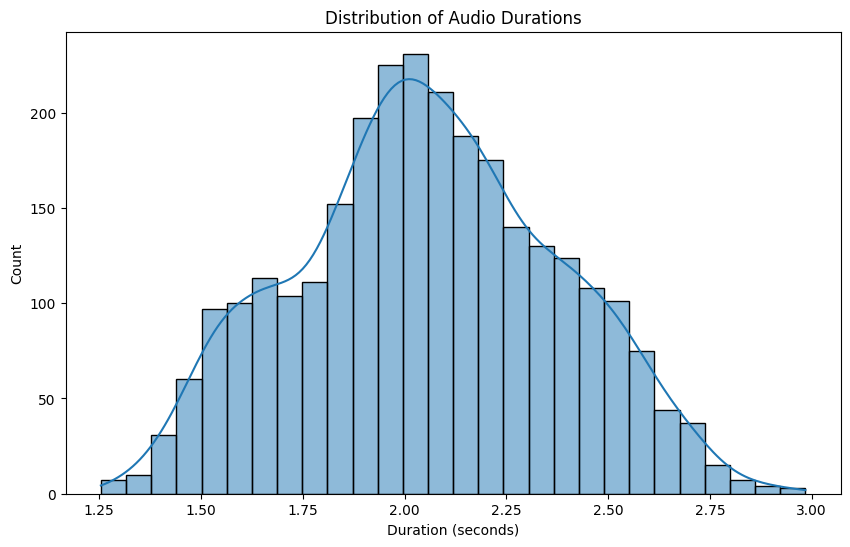

In [33]:
# Histogram of audio durations
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['duration'], kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

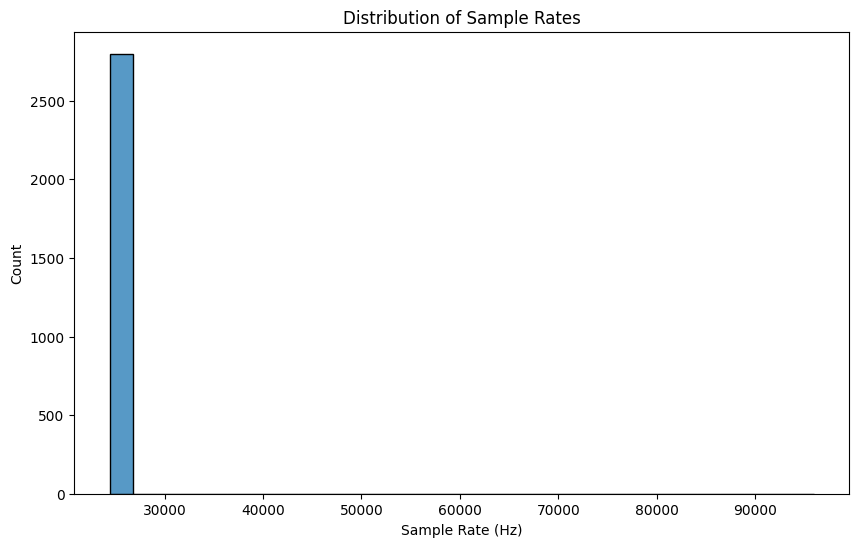

In [34]:
# Histogram of sample rates
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['sample_rate'], bins=30, kde=False)
plt.title('Distribution of Sample Rates')
plt.xlabel('Sample Rate (Hz)')
plt.ylabel('Count')
plt.show()

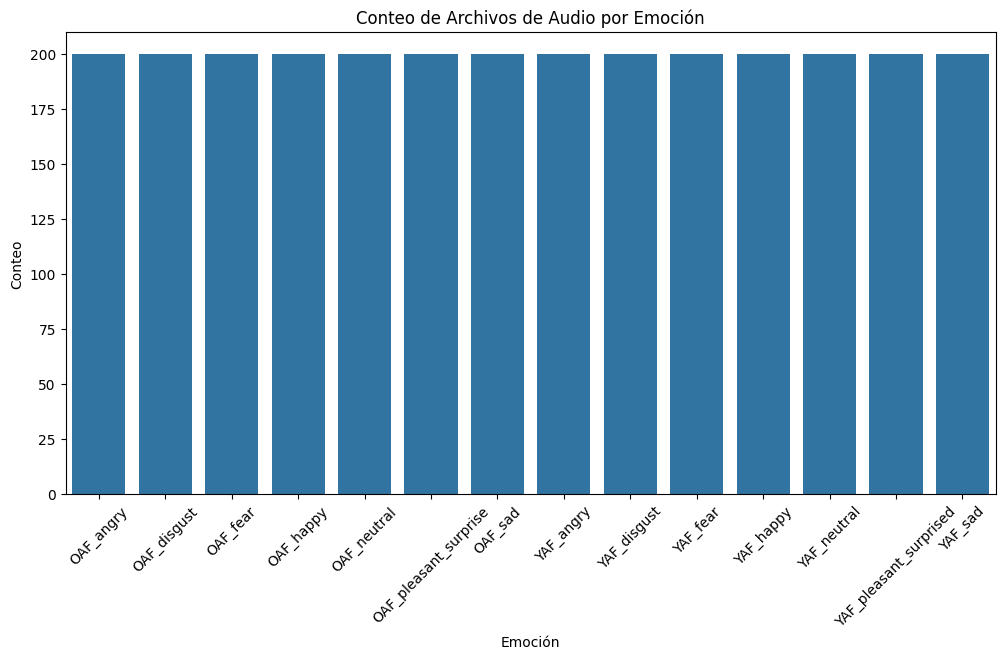

In [35]:
# Gráfico de barras del conteo de archivos por emoción
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='emotion')
plt.title('Conteo de Archivos de Audio por Emoción')
plt.xlabel('Emoción')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()

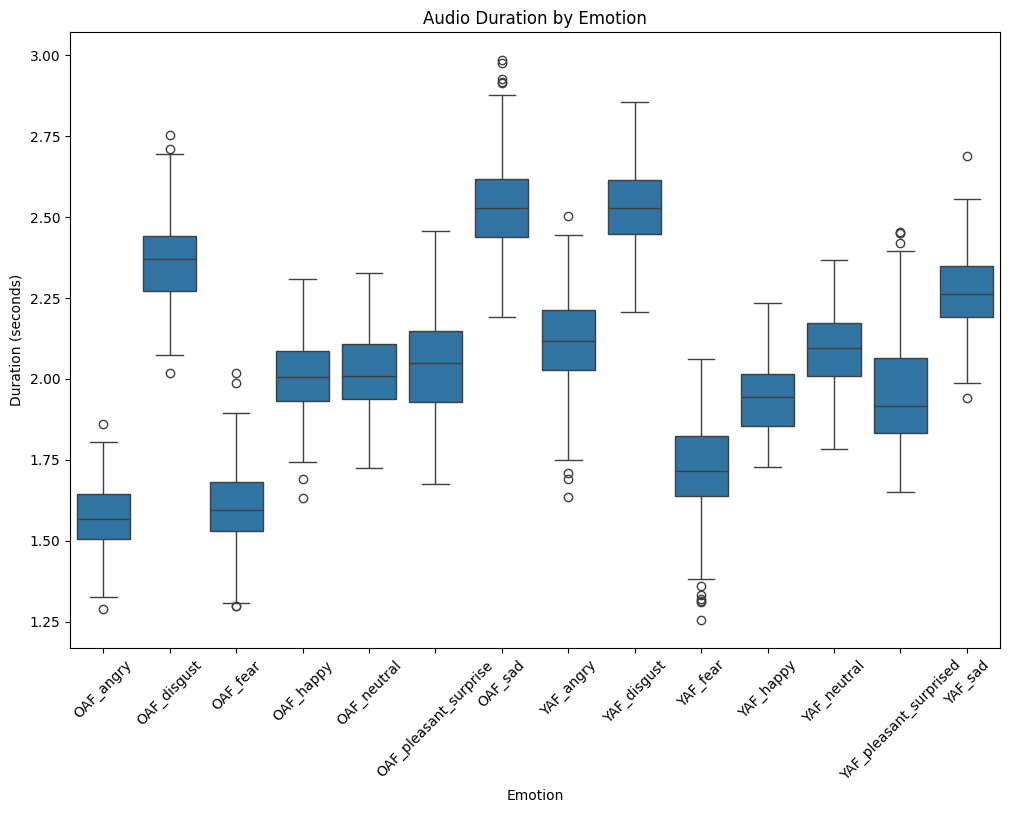

In [36]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean, x='emotion', y='duration')
plt.title('Audio Duration by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

# Modelado
#### Procedamos a crear un modelo utilizando el conjunto de datos proporcionado para el entrenamiento.

# Extracción de Características
#### Extracción de características de tus archivos de audio utilizando los coeficientes cepstrales de frecuencia mel (MFCCs) como características, que son comúnmente utilizados en tareas de procesamiento de voz y audio.

In [37]:
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, {e}")
        return None 
    return mfccs_processed

df['features'] = df['file_path'].apply(extract_features)

# Preparación de Datos
#### Preparando el conjunto de datos para el entrenamiento, incluyendo la división en conjuntos de entrenamiento y prueba, y la codificación de las etiquetas.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion'])

# Split data
X = np.array(df['features'].tolist())
y = to_categorical(df['emotion_encoded'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del Modelo
#### Definiendo un modelo simple de Red Neuronal Convolucional (CNN) adecuado para datos unidimensionales como los MFCCs.

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 36, 64)            384       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 18, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 128)           41088     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

# Model Training

In [40]:
# Reshape X_train and X_test to add an extra dimension expected by Conv1D layers
X_train_reshaped = X_train[..., np.newaxis]
X_test_reshaped = X_test[..., np.newaxis]

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=30,  # The number of epochs to train for
    batch_size=32,  # The size of the batches of data
    validation_data=(X_test_reshaped, y_test)
)

Epoch 1/30
70/70 [==============================] - 2s 10ms/step - loss: 1.4324 - accuracy: 0.6018 - val_loss: 0.1656 - val_accuracy: 0.9714
Epoch 2/30
70/70 [==============================] - 0s 7ms/step - loss: 0.3323 - accuracy: 0.8893 - val_loss: 0.0662 - val_accuracy: 0.9821
Epoch 3/30
70/70 [==============================] - 0s 6ms/step - loss: 0.1720 - accuracy: 0.9393 - val_loss: 0.0335 - val_accuracy: 0.9911
Epoch 4/30
70/70 [==============================] - 0s 6ms/step - loss: 0.1372 - accuracy: 0.9567 - val_loss: 0.0251 - val_accuracy: 0.9946
Epoch 5/30
70/70 [==============================] - 0s 7ms/step - loss: 0.0934 - accuracy: 0.9701 - val_loss: 0.0295 - val_accuracy: 0.9946
Epoch 6/30
70/70 [==============================] - 0s 5ms/step - loss: 0.1013 - accuracy: 0.9652 - val_loss: 0.0107 - val_accuracy: 0.9964
Epoch 7/30
70/70 [==============================] - 0s 5ms/step - loss: 0.0579 - accuracy: 0.9830 - val_loss: 0.0092 - val_accuracy: 0.9964
Epoch 8/30
70/70 [=

In [41]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f"Precisión en prueba: {test_accuracy * 100:.2f}%\nPérdida en prueba: {test_loss}")

18/18 - 0s - loss: 0.0077 - accuracy: 0.9982 - 81ms/epoch - 5ms/step
Precisión en prueba: 99.82%
Pérdida en prueba: 0.007736834231764078


# Predicción de Muestra
#### Vamos a definir una función llamada "predict" que tomará como entrada la ruta de un archivo de audio y dará como salida la emoción predicha.

In [42]:
# Definiendo la función para extraer características MFCC de un archivo de audio
def extract_features_for_prediction(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encontrado al analizar el archivo: {file_path}, {e}")
        return None 
    return mfccs_processed

def predict(file_path):
    new_audio_features = extract_features_for_prediction(file_path)

    # Si la extracción de características fue exitosa, remodelar las características y predecir usando el modelo entrenado
    if new_audio_features is not None:
        new_audio_features_reshaped = new_audio_features[np.newaxis, ..., np.newaxis]
        predicted_vector = model.predict(new_audio_features_reshaped)
        predicted_class = np.argmax(predicted_vector, axis=1)

        # Suponiendo que el 'LabelEncoder' 'le' ya está ajustado con las etiquetas de emociones
        predicted_emotion = le.inverse_transform(predicted_class)
        
        # Obtiene la etiqueta predicha como una cadena y la limpia eliminando el prefijo "OAF_" o "YAF_"
        emotion_label = predicted_emotion[0]
        cleaned_emotion = emotion_label.split("_")[-1]
        
        print(f"La emoción predicha es: {cleaned_emotion}")
    else:
        print("No se pudo procesar el archivo de audio para la predicción.")

## Hemos proporcionado una carpeta /test con muestras de cada emoción fuera del conjunto de datos de entrenamiento. Para otras pruebas, coloca tus archivos de audio en la carpeta /tests y cambia la ruta del archivo en la función predict.

In [43]:
ipd.Audio(filename='tests/test_surprised.mp3')

In [44]:
file_path_to_predict = 'tests/test_surprised.mp3'

predict(file_path_to_predict)

1/1 [==============================] - 0s 87ms/step
La emoción predicha es: surprised
